# Train smarter Naive Bayes model with labelled data

The running of this script creates new pickle object with Naive Bayes model. Periodically run the notebook and replace the pickle file in object with a new one as it only gets better with more data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('articles.csv', header=None)
df.columns = ['index','date', 'title' ,'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df = df[['text', 'checked_label']]
df[df['checked_label'] == 'geberal'] = 'general'
df = df.dropna()
df = df[df['checked_label'] != 'actual_label']
df.shape

(635, 2)

In [4]:
df['checked_label'].value_counts()

web/mobile         235
general            180
job/career         104
devops/OS           49
AI/Data Science     46
finance             21
Name: checked_label, dtype: int64

In [5]:
df['checked_label'].unique()

array(['general', 'finance', 'devops/OS', 'job/career', 'web/mobile',
       'AI/Data Science'], dtype=object)

We gonna take some finance, ai/data science and devops/os data from another df. This is not a "News" object as 'df' but they are still manually labeled and in the style of the articles so this should solve the under represented distribution.

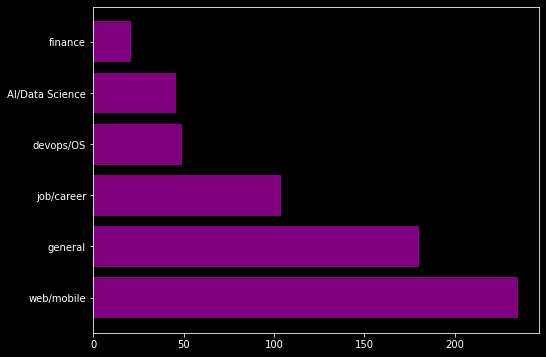

In [6]:
plt.figure(figsize=[8,6])
plt.barh(df['checked_label'].value_counts().index, df['checked_label'].value_counts(), color='purple')
plt.grid(False)

This looks well distributed now. We are going to have to clean the junk out of the text.

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r"&#x27;", "", text)
    text = re.sub(r"&gt;", "", text)
    text = re.sub(r"&#x2F;", "", text)
    text = re.sub(r"<[^>]*>", "", text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [8]:
df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(remove_stopwords)

In [9]:
df

,text,checked_label
1,given hundreds dollars breaking federal laws k...,general
2,hello world name nilay cofounder jorge founded...,general
3,early stage maker manage funds expenses full f...,finance
4,e breaking sha encryption,devops/OS
5,hey hn p quinn kristine quadrant eye href http...,general
...,...,...
631,php classic asp server side scripting language...,web/mobile
632,hi want present latest product numbra p workin...,web/mobile
633,hi hn p recommendations getting speed quickly ...,AI/Data Science
634,inspired https xf xf news ycombinator com xf i...,general


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [10]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['text'])

In [11]:
x_train = x_train.toarray()

In [12]:
df['checked_label'].unique()

array(['general', 'finance', 'devops/OS', 'job/career', 'web/mobile',
       'AI/Data Science'], dtype=object)

In [13]:
df['checked_label'] = df['checked_label'].map({'AI/Data Science': 0, 'devops/OS': 1, 'finance': 2, 
                                               'general': 3, 'job/career': 4,  'web/mobile': 5})
y_train = df['checked_label'] 

In [14]:
x_train.shape, y_train.shape

((635, 7864), (635,))

## Oversample with SMOTE

We have decent amount of data but we are manually labeling it so its not near enough and we don't want this process to take too long. So we will use SMOTE from imbalanced learn which will generate similar points using  Synthetic Minority Over-sampling.

In [15]:
smote = SMOTE(sampling_strategy= {0: 300, 1: 300, 2:300, 3 : 300, 4: 300, 5:300})

In [16]:
new_x, new_y = smote.fit_resample(x_train, y_train)

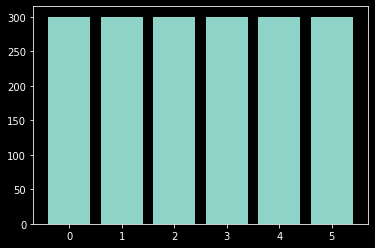

In [17]:
plt.bar(new_y.value_counts().index, new_y.value_counts());

## Split into train - test 


In [18]:
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.3, random_state=42, stratify=new_y)

In [19]:
x_train.shape, y_train.shape

((1260, 7864), (1260,))

In [20]:
x_test.shape, y_test.shape

((540, 7864), (540,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [21]:
params = {'alpha': [0, 0.2, 0.5, 0.7, 1, 2, 5], 'norm': [True, False]}

In [22]:
grid = GridSearchCV(ComplementNB(), param_grid = params, n_jobs= -1)
grid.fit(x_train, y_train)
best_scores = grid.best_params_
best_scores

{'alpha': 0, 'norm': False}

In [23]:
nb = ComplementNB(alpha = best_scores['alpha'], norm = best_scores['norm'])

In [24]:
nb.fit(x_train, y_train)

ComplementNB(alpha=0)

In [25]:
preds = nb.predict(x_test)

In [26]:
def print_metrics(model, predictions):
    print(f'Train Accuracy: {model.score(x_train, y_train)}')
    print(f'Test Accuracy: {model.score(x_test, y_test)}')
    print(f'F1 score: {f1_score(predictions, y_test, average = "weighted")}')

In [27]:
print_metrics(nb, preds)

Train Accuracy: 0.996031746031746
Test Accuracy: 0.9333333333333333
F1 score: 0.9349980187483551


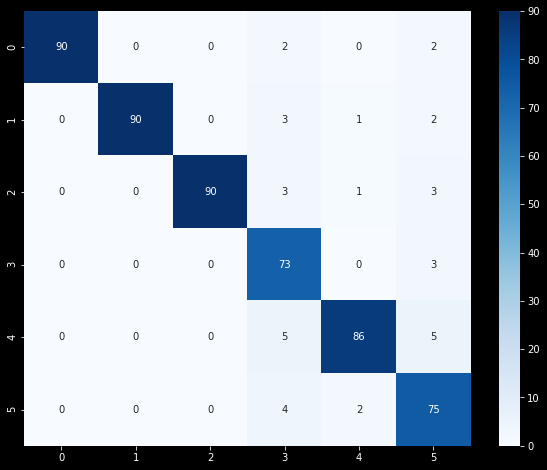

In [28]:
def show_confusion_matrix(predictions):
    conf_matrix = confusion_matrix(predictions, y_test)
    plt.figure(figsize=[10,8])
    sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues');

show_confusion_matrix(preds)

## Logistic Regression

In [29]:
params = {'penalty': ['l1', 'l2'], 
          'C': [1e-3, 1e-4, 1e-5, 1e-2, 1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7], 
          'class_weight': ['balanced', None], 
          'fit_intercept': [True, False]}
grid = GridSearchCV(LogisticRegression(), param_grid = params, n_jobs= -1)
grid.fit(x_train, y_train)
best_scores = grid.best_params_
best_scores

{'C': 100.0,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'penalty': 'l2'}

In [30]:
lr = LogisticRegression(C = best_scores['C'], 
                        penalty = best_scores['penalty'], 
                        class_weight = best_scores['class_weight'], 
                        fit_intercept = best_scores['fit_intercept'])

In [31]:
lr.fit(x_train, y_train)

LogisticRegression(C=100.0, class_weight='balanced')

In [32]:
predictions = lr.predict(x_test)

In [33]:
print_metrics(lr, predictions)

Train Accuracy: 0.9992063492063492
Test Accuracy: 0.95
F1 score: 0.9500533421402662


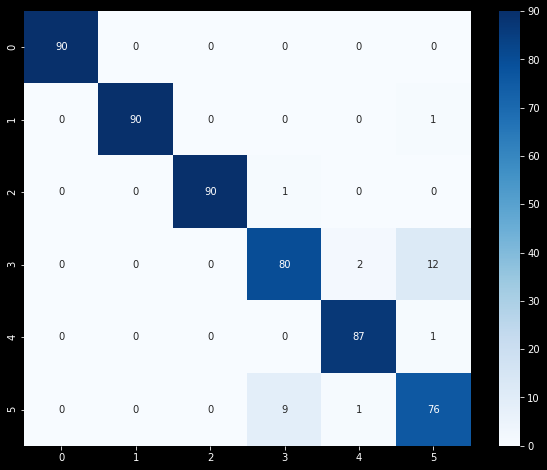

In [34]:
show_confusion_matrix(predictions)

## Save model

Let's create a pipeline that will make the code more concise the model when serves in production.

In [35]:
pipe = Pipeline([('vectorizer', vectorizer), ('nb', lr)])

In [36]:
def test_with_random_text(txt):
    txt = clean_text(txt)
    txt = remove_stopwords(txt)
    pred = pipe.predict([txt])
    return pred

In [37]:
pred = test_with_random_text('Java Script rules the web due to React')
pred

array([5])

In [38]:
pred = test_with_random_text('This is all about politics.Covid was release by China as attempt to destroy US economy')
pred

array([3])

In [39]:
pred = test_with_random_text('This Machine Learning Model required more hyperparameters tuning.')
pred

array([0])

In [40]:
pred = test_with_random_text('Ubuntu is the most mature Linux distribution')
pred

array([1])

In [41]:
import pickle
save_classifier = open("lr.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()